In [1]:
from pydaqmx_helper.adc import ADC
from pydaqmx_helper.dac import DAC

In [37]:
from tqdm import tqdm
from glob import glob
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit

In [3]:
thermocoupleADC = ADC()
thermocoupleDAC = DAC(0)

In [4]:
thermocoupleADC.addChannels([0, 1, 2, 3, 4, 5, 6, 7], ADC_mode="DAQmx_Val_RSE")
thermocoupleADC.getActiveChannels()

Activated Channel 0
Activated Channel 1
Activated Channel 2
Activated Channel 3
Activated Channel 4
Activated Channel 5
Activated Channel 6
Activated Channel 7


[0, 1, 2, 3, 4, 5, 6, 7]

In [5]:
thermocoupleADC.sampleVoltages()

{0: (-0.10617478582271289,),
 1: (-0.1060742698939201,),
 2: (-0.09717677598300511,),
 3: (-0.10655382743349762,),
 4: (-0.14797435425530736,),
 5: (-0.1487397358162248,),
 6: (-0.12784428966143224,),
 7: (-0.14872219201377845,)}

# Calibration

In [6]:
# Need to convert from adc pin voltage to temperature

In [2]:
def SwitchPinLayer(dac, layer):
    
    # We have 16 thermocouples but only 8 ADC ouptuts, a 16 to 8 channel switch is used
    # We describe the two sets of thermocouples as layers, and switch between them using this function
    # This function sets voltage switch to the value corresponding to the 'layer' parameter which is 0 or 1
    
    if layer == 0:
        dac.writeVoltage(0)
        
    elif layer == 1:
        dac.writeVoltage(5)
        
    else:
        raise ValueError("Parameter: 'Layer' must be of type int and either 0 or 1")
        
    return

In [3]:
def MeasureTemperatures(adc, dac, calibrationFunction=None):
    # Function to record the temperatures of all the pins
    # Returns a list with the length of the number of pins, with each value being the voltage of pin 'i'.
    
    # Define a new list containing thermocouple outputs
    
    temperatures = list()
    
    # First ensure pin switch is on layer 0
    SwitchPinLayer(dac, 0)
    
    # Record voltages for each pin
    firstPins = adc.sampleVoltages()
    
    for el in firstPins.values():
        temperatures.append(el[0]) # first element of el is needed as the values of the returned dictionary are tuples
    
    # Switch pins to second layer
    SwitchPinLayer(dac, 1)
    
    # Record voltages for each pin
    secondPins = adc.sampleVoltages()
    
    for el in secondPins.values():
        
        temperatures.append(el[0])
        
    return temperatures

In [10]:
MeasureTemperatures(thermocoupleADC, thermocoupleDAC)

[-0.11639078776145695,
 -0.1060742698939201,
 -0.09717677598300511,
 -0.10655382743349762,
 -0.14797435425530736,
 -0.1487397358162248,
 -0.11762786199781416,
 -0.13850665213091062,
 -0.14703879357769978,
 -0.14692910546706628,
 -0.1278601095112073,
 -0.14741423003474807,
 -0.11733038397550288,
 -0.12831033659244184,
 -0.11762786199781416,
 -0.12829111224804635]

In [4]:
def SaveCalibrationData(path, temperature):
    data = MeasureTemperatures(thermocoupleADC, thermocoupleDAC)
    
    fullPath = path + "/nc_calibration_" + str(temperature)

    np.savetxt(fullPath, data)

In [15]:
SaveCalibrationData(r"C:\Users\Student\Desktop\20302561\Calibration", "test")

In [152]:
SaveCalibrationData(r"C:\Users\Student\Desktop\20302561\Calibration", 71.5)

## Loading Calibration Data

In [75]:
def GetCalibrationData(path):
    paths = glob(path)
    paths.sort(key = lambda x: float(x.split('_')[-1]))
    
    data = [0] * len(paths)
    temperature = [float(el.split('_')[-1]) for el in paths]
    
    for i, path in enumerate(paths):
        data[i] = np.loadtxt(path)

    return [temperature, np.array(data)]

In [142]:
def QuadraticFit(x, a, b, c):

    if type(x) == np.dtype('float64'):
        x = [x]

    output = []

    for el in x:
        output.append(a*el**2 + b*el + c)

    return output

In [78]:
def PlotCalibration(calibrationData):

    fig, ax = plt.subplots()
    
    pins = [ calibrationData[1][:,i] for i in range(len(calibrationData[1]))]

    fitPars = []

    for i, pinValues in enumerate(pins):
        
        ax.errorbar(calibrationData[0], pinValues, xerr=0.5, fmt=".", color=plt.get_cmap("viridis").__call__(i / 16))

        #print(calibrationData[0])
        #print(pinValues)

        pars, cov = curve_fit(LinearFit, calibrationData[0], pinValues)

        ax.plot(calibrationData[0], LinearFit(calibrationData[0], pars[0], pars[1], pars[2]), color=plt.get_cmap("viridis").__call__(i / 16))

        fitPars.append(pars)
    
    return fitPars

In [162]:
def CreateCalibrationFunction(fitPars):

    def CalibrationFunction(voltages):

        temperatures = []

        for i, pinVoltage in enumerate(voltages):

            quadratic = np.polynomial.Polynomial(np.flip(fitPars[i]))

            roots = (quadratic - pinVoltage).roots()
            
            for r in roots:
                if r > 0:
                    root = r

            temperatures.append(root)

        return temperatures

    return CalibrationFunction

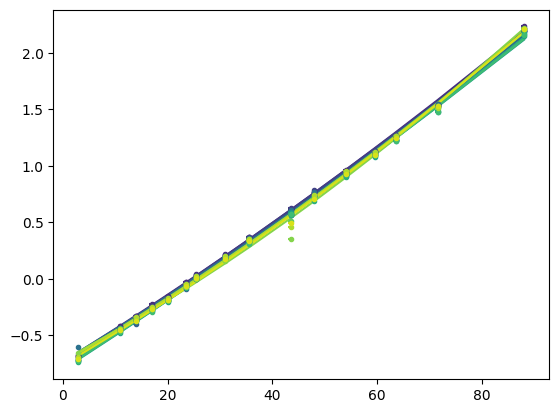

In [163]:
calibrationData = GetCalibrationData(r"../data/calibration/*")
fitPars = PlotCalibration(calibrationData)
CalibrationFunction = CreateCalibrationFunction(fitPars)

# Experiment

In [15]:
def ExperimentRun(measurements, timeBetween):

    # measurements: Number of measurements to be made
    # timeBetween: Time to wait between each measurment (seconds)

    # files containing the data for each measurment will be saved before the next one begins

    startTime = time.time()

    for i in tqdm(range(measurements)):

        print(f"Taking measurment {i} of {measurements}")

        ## DO MEASUREMENT

        print("Measurment complete, writing to file")

        currentTime = time.time() - startTime
        currentTimeRounded = int(currentTime)

        ## Write to file. Note that filename should contain the time at which the measurment was taken

        print(f"Waiting {timeBetween} seconds")
        
        time.sleep(timeBetween)

    print("All measurments complete, exiting function")
    totalTime = time.time() - startTime
    print(f"Total time ellapsed: {totalTime}")

    return

In [16]:
ExperimentRun(3, 5)

  0%|          | 0/3 [00:00<?, ?it/s]

Taking measurment 0 of 3
Measurment complete, writing to file
Waiting 5 seconds


 33%|███▎      | 1/3 [00:05<00:10,  5.00s/it]

Taking measurment 1 of 3
Measurment complete, writing to file
Waiting 5 seconds


 67%|██████▋   | 2/3 [00:10<00:05,  5.00s/it]

Taking measurment 2 of 3
Measurment complete, writing to file
Waiting 5 seconds


100%|██████████| 3/3 [00:15<00:00,  5.00s/it]

All measurments complete, exiting function
Total time ellapsed: 15.013916254043579


## Plotting

In [9]:
def GetData(path):
    paths = glob(path)
    paths.sort(key = lambda x: float(x.split('_')[-1]))
    
    data = [0] * len(paths)
    time = [float(el.split('_')[-1]) for el in paths]

    for i, path in enumerate(paths):
        data[i] = np.loadtxt(path)
    
    return [time, np.array(data)]

In [11]:
testRun = GetData("/home/daraghhollman/Main/ucd_4thYearLabs/NewtonsCooling/data/run_one_cont/*")

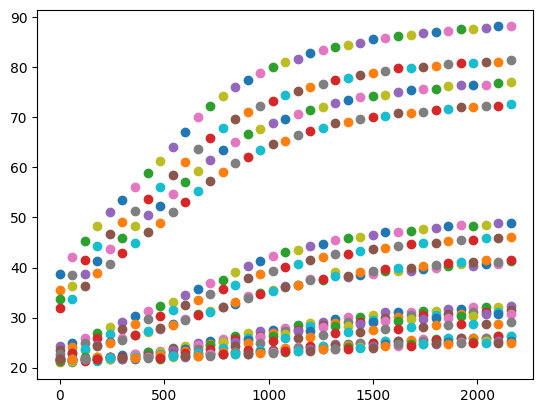

In [164]:
for i, (time, pinVoltages) in enumerate(zip(testRun[0], testRun[1])):

    temperatures = CalibrationFunction(pinVoltages)

    for t in temperatures:
        plt.scatter(time, t)